In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, KBinsDiscretizer, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RizkyRahmadian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RizkyRahmadian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RizkyRahmadian\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RizkyRahmadian\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RizkyRahmadian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
df = pd.read_csv("WELFake_Dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [21]:
df = df.fillna('')

In [8]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
title_text    0
text_len      0
word_count    0
dtype: int64

In [ ]:
print(df['label'].value_counts())

label
1    37106
0    35028
Name: count, dtype: int64


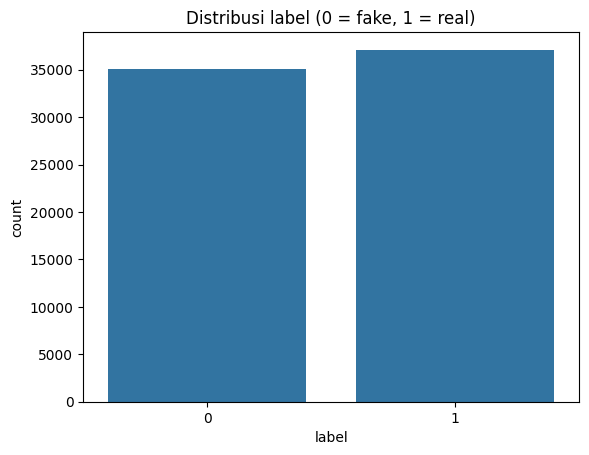

In [ ]:
sns.countplot(x='label', data=df)
plt.title("Distribusi label (0 = fake, 1 = real)")
plt.show()

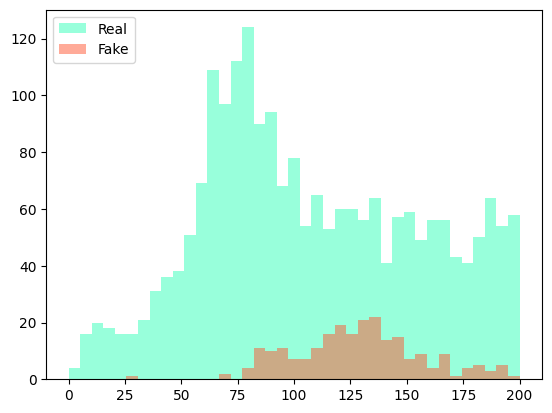

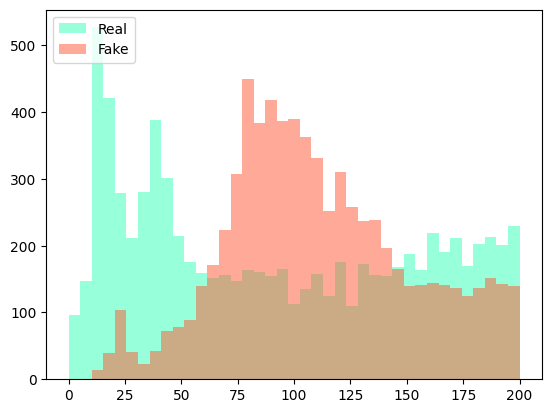

In [22]:
df["title_text"] = df["title"] + df["text"]
df['text_len'] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df['word_count'] = df["title_text"].apply(lambda x: len(str(x).split(" ")))
bins = np.linspace(0, 200, 40)
plt.hist(df[df["label"]== 1]["text_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["text_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()
plt.hist(df[df["label"]== 1]["word_count"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["word_count"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()

# Text Preprocessing

In [23]:
def text_preprocessing(text):
    # --- A. Case Folding ---
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    # --- B. Tokenization ---
    tokens = word_tokenize(text)

    # Inisialisasi Lemmatizer dan Stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # --- C. Stopword Removal & D. Lemmatization ---
    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
    #         clean_token = lemmatizer.lemmatize(token)
            clean_tokens.append(token)

    return " ".join(clean_tokens)

# Title

In [24]:
y_title = df['label']
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(df['title'], y_title, test_size=0.2, random_state=53)

## Wordcloud

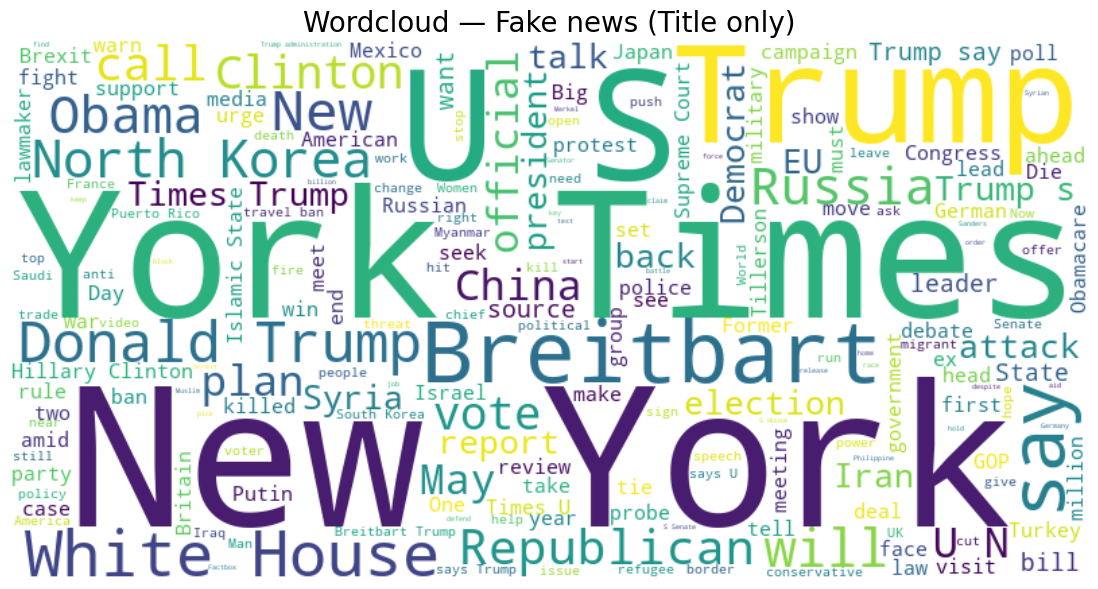

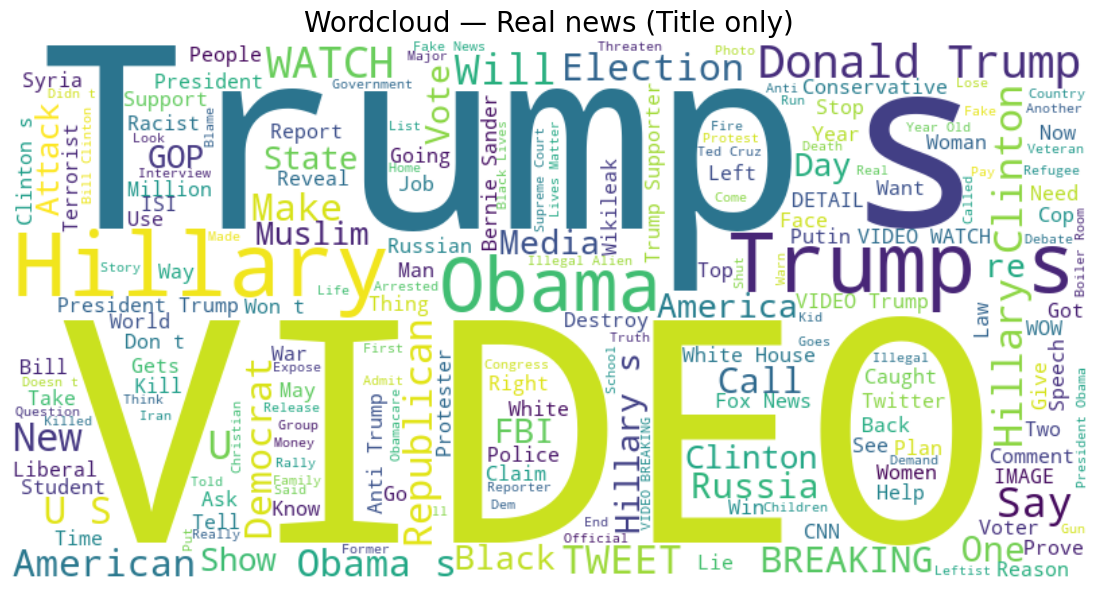

In [25]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train_title[y_train_title==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title only)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title

In [27]:
X_train_title = [text_preprocessing(text) for text in X_train_title]
X_test_title = [text_preprocessing(text) for text in X_test_title]

In [28]:
tfidf_title = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train_title = tfidf_title.fit_transform(X_train_title)
tfidf_test_title = tfidf_title.transform(X_test_title)

### 100% Data Train

In [29]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title, y_train_title)
    
y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 100% data): 0.8928398142371942


In [30]:
nb = MultinomialNB()
nb.fit(tfidf_train_title, y_train_title)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy (trained on 100% data): 0.8707284951826436


In [31]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title, y_train_title)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_rf))

KeyboardInterrupt: 

In [26]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title, y_train_title)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 100% data): 0.8374575448811257


In [27]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title, y_train_title)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 100% data): 0.9060788798780065


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

### 50% Data Train

In [11]:
tfidf_train_title_50, _, y_train_title_50, _ = train_test_split(
    tfidf_train_title, 
    y_train_title, 
    train_size=0.5,
    random_state=42,
    stratify=y_train_title
)

In [ ]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title_50, y_train_title_50)

y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred))

Accuracy (trained on 50% data): 0.8875025992929924


In [ ]:
nb = MultinomialNB()
nb.fit(tfidf_train_title_50, y_train_title_50)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy: 0.8684411173494143


In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title_50, y_train_title_50)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy: 0.8830664725861233


In [15]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title_50, y_train_title_50)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.8308726693006169


In [16]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title_50, y_train_title_50)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.8939488459139114


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

### 10% Data Train

In [17]:
tfidf_train_title_10, _, y_train_title_10, _ = train_test_split(
    tfidf_train_title, 
    y_train_title, 
    train_size=0.1,
    random_state=42,
    stratify=y_train_title
)

In [18]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title_10, y_train_title_10)

y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8637970472031608


In [19]:
nb = MultinomialNB()
nb.fit(tfidf_train_title_10, y_train_title_10)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy (trained on 10% data): 0.8580439453801899


In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title_10, y_train_title_10)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.847438829971581


In [21]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title_10, y_train_title_10)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.814583766548832


In [22]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title_10, y_train_title_10)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.866916198793928


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

## BERT Title

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def bert_embed_batched(texts, tokenizer, model, batch_size=32, max_length=128):
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i : i + batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            output = model(**encoded)
            
        token_embeddings = output.last_hidden_state
        
        attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
        
        sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
        
        sum_embeddings = torch.sum(token_embeddings * attention_mask, 1)
        
        mean_embeddings = sum_embeddings / sum_mask
        
        all_embeddings.append(mean_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

X_train_title = X_train_title.astype(str).tolist()
X_test_title  = X_test_title.astype(str).tolist()

bert_train_title = bert_embed_batched(X_train_title, tokenizer, bert_model, batch_size=32)
bert_test_title = bert_embed_batched(X_test_title, tokenizer, bert_model, batch_size=32)

Using device: cpu


Generating Embeddings:  17%|█▋        | 305/1804 [04:41<23:02,  1.08it/s]


KeyboardInterrupt: 

### 100% Data Train

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title, y_train_title)
    
y_pred_logistic = Logistic.predict(bert_test_title)
print("Logistic Regression Accuracy:", accuracy_score(y_test_title, y_pred_logistic))

Logistic Regression Accuracy: 0.9422610383309074


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy: 0.8502114091633742


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title, y_train_title)
    
y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy:", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy: 0.9552921605323352


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title, y_train_title)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy:", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy: 0.9548069591737715


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title, y_train_title)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy:", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy: 0.9518264365425938


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

### 50% Data Train

In [ ]:
bert_train_title_50, _, y_train_title_50, _ = train_test_split(
    bert_train_title, 
    y_train_title, 
    train_size=0.5,
    random_state=42,
    stratify=y_train_title
)

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title_50, y_train_title_50)

y_pred = Logistic.predict(bert_test_title)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.9333887849171691


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title_50)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title_50)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy (trained on 50% data): 0.8505579815623484


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title_50, y_train_title_50)

y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.9414292645733694


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title_50, y_train_title_50)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.950509461426492


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title_50, y_train_title_50)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.9433007555278298


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

### 10% Data Train

In [ ]:
bert_train_title_10, _, y_train_title_10, _ = train_test_split(
    bert_train_title, 
    y_train_title, 
    train_size=0.1,
    random_state=42,
    stratify=y_train_title
)

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title_10, y_train_title_10)

y_pred = Logistic.predict(bert_test_title)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8637970472031608


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title_10)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title_10)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy (trained on 10% data): 0.8580439453801899


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title_10, y_train_title_10)

y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.847438829971581


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title_10, y_train_title_10)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.814583766548832


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title_10, y_train_title_10)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.866916198793928


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))

# Title + Text

In [5]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], y, test_size=0.2, random_state=53)

## Wordcloud

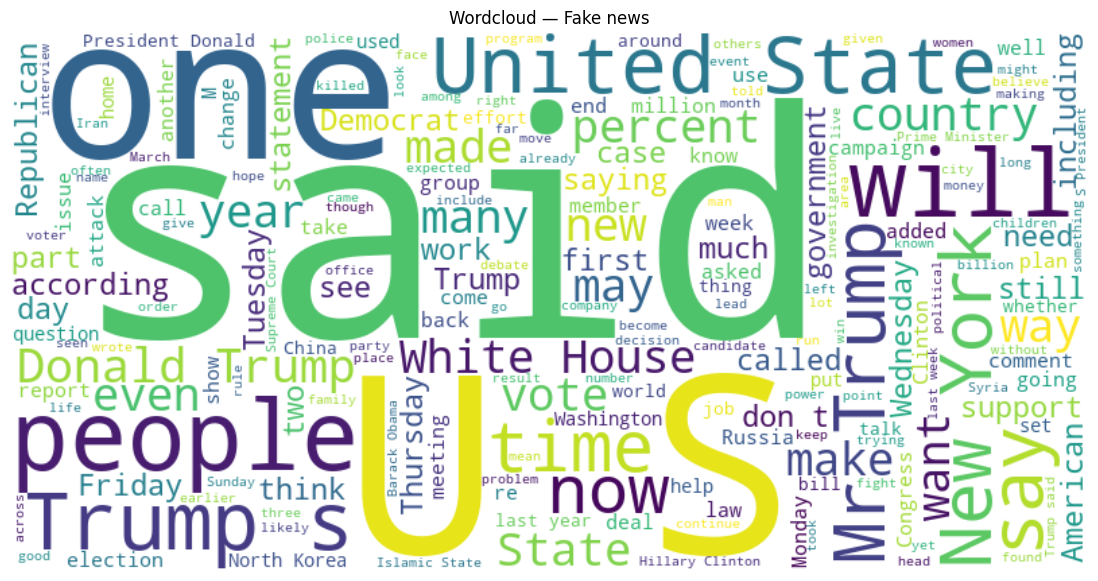

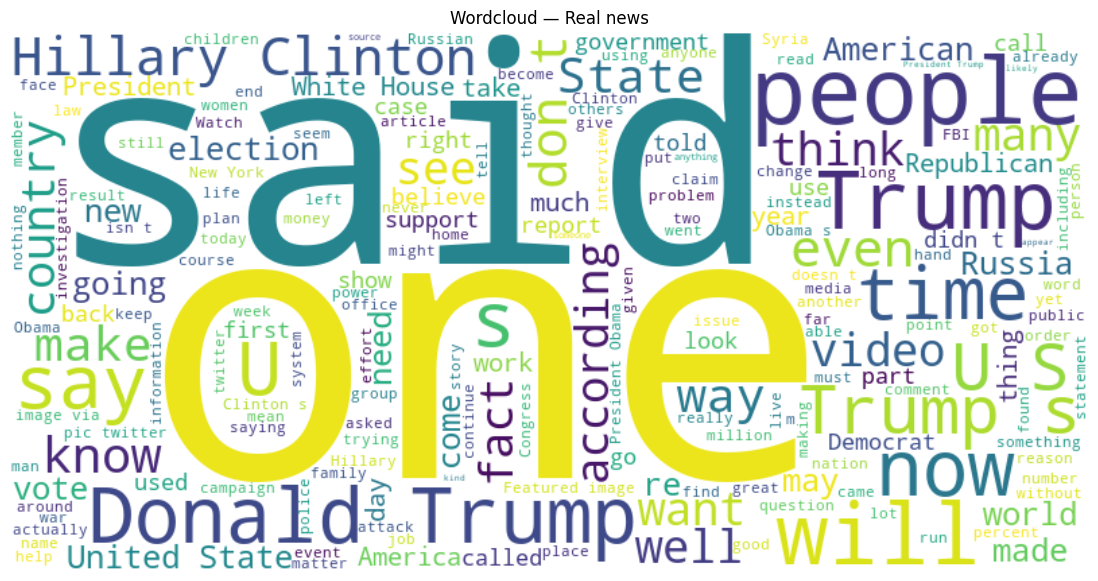

In [ ]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train[y_train==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title + Text)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title + Text

In [6]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

### 100% Data Train

In [ ]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train, y_train)
    
y_pred_logistic = Logistic.predict(tfidf_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.9422610383309074


In [ ]:
nb = MultinomialNB()
nb.fit(tfidf_train, y_train)

y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8502114091633742


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train, y_train)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9552921605323352


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train, y_train)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9548069591737715


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train, y_train)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy: 0.9518264365425938


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

### 50% Data Train

In [7]:
tfidf_train_50, _, y_train_50, _ = train_test_split(
    tfidf_train, 
    y_train, 
    train_size=0.5,
    random_state=42,
    stratify=y_train
)

In [8]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_50, y_train_50)

y_pred = Logistic.predict(tfidf_test)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.9333887849171691


In [9]:
nb = MultinomialNB()
nb.fit(tfidf_train_50, y_train_50)
    
y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy (trained on 50% data): 0.8505579815623484


In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_50, y_train_50)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.9414292645733694


In [11]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_50, y_train_50)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.950509461426492


In [12]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_50, y_train_50)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.9433007555278298


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

### 10% Data Train

In [ ]:
tfidf_train_10, _, y_train_10, _ = train_test_split(
    tfidf_train, 
    y_train, 
    train_size=0.1,
    random_state=42,
    stratify=y_train
)

In [ ]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_10, y_train_10)

y_pred = Logistic.predict(tfidf_test)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8637970472031608


In [ ]:
nb = MultinomialNB()
nb.fit(tfidf_train_10, y_train_10)
    
y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy (trained on 10% data): 0.8580439453801899


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_10, y_train_10)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.847438829971581


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_10, y_train_10)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.814583766548832


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_10, y_train_10)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.866916198793928


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

## BERT Title + Text

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def bert_embed_batched(texts, tokenizer, model, batch_size=32, max_length=128):
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i : i + batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            output = model(**encoded)
            
        token_embeddings = output.last_hidden_state
        
        attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
        
        sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
        
        sum_embeddings = torch.sum(token_embeddings * attention_mask, 1)
        
        mean_embeddings = sum_embeddings / sum_mask
        
        all_embeddings.append(mean_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()

bert_train = bert_embed_batched(X_train, tokenizer, bert_model, batch_size=32)
bert_test = bert_embed_batched(X_test, tokenizer, bert_model, batch_size=32)

### 100% Data Train

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train, y_train)
    
y_pred_logistic = Logistic.predict(bert_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.9422610383309074


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train)
    
y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy: 0.8502114091633742


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train, y_train)
    
y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9552921605323352


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train, y_train)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9548069591737715


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train, y_train)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy: 0.9518264365425938


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

### 50% Data Train

In [ ]:
bert_train_50, _, y_train_50, _ = train_test_split(
    bert_train, 
    y_train, 
    train_size=0.5,
    random_state=42,
    stratify=y_train
)

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_50, y_train_50)

y_pred = Logistic.predict(bert_test)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.9333887849171691


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_50)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_50)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy (trained on 50% data): 0.8505579815623484


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_50, y_train_50)

y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.9414292645733694


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_50, y_train_50)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.950509461426492


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_50, y_train_50)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.9433007555278298


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

### 10% Data Train

In [ ]:
bert_train_10, _, y_train_10, _ = train_test_split(
    bert_train, 
    y_train, 
    train_size=0.1,
    random_state=42,
    stratify=y_train
)

In [ ]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_10, y_train_10)

y_pred = Logistic.predict(bert_test)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8637970472031608


In [ ]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_10)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_10)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy (trained on 10% data): 0.8580439453801899


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_10, y_train_10)

y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.847438829971581


In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_10, y_train_10)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.814583766548832


In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_10, y_train_10)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.866916198793928


#### Evaluasi

In [ ]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))

## BERT Fine Tune